# Neural Networks Coursework Notebook

Learning outcomes

1. Experience building and training Artificial Neural Networks (ANNs) for classification
problems.
2. Experience preprocessing image datasets.
3. Experience implementing and testing neural networks in Python using
PyTorch/TensorFlow.
4. Experience comparing different neural architectures (ANN vs. CNN)

Dataset
1. https://github.com/zalandoresearch/fashion-mnist
2. Description: 60,000 training and 10,000 testing grayscale images (28×28 pixels), belonging to 10 clothing categories such as T-shirt, trousers, pullover, dress, coat, sandal, shirt, sneaker, bag, and ankle boot.
3. Task: Classify each image into one of the 10 categories

Tasks
1. Load the Dataset: Use the Fashion-MNIST dataset available in
torchvision.datasets (PyTorch) or keras.datasets (TensorFlow).
2. Data Preprocessing:
o Normalize pixel values.
o Split data into training, validation, and test sets.
3. Model Design:
o Implement a simple ANN (MLP).
o Implement a CNN for comparison.
4. Training and Testing:
o Train the networks on the dataset.
o Evaluate using test accuracy and confusion matrix.
5. Analysis and Innovation:
o Compare ANN vs. CNN performance.
o Highlight confusion between visually similar classes (e.g., shirt vs. coat).
o Suggest improvements (e.g., data augmentation, dropout, optimizer choice)

# Load the dataset

In [ ]:
#Data inputs
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)

TensorFlow version: 2.19.0
NumPy version: 2.0.2


In [ ]:
#Load the data froom the fashion-MNIST dataset - 80/20 split
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print("Training data shape:", train_images.shape)
print("Testing data shape:", test_images.shape)

Training data shape: (60000, 28, 28)
Testing data shape: (10000, 28, 28)


In [ ]:
#Split the training data into training and validation sets - aproximately split 70/15/15 between train/test/validate
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=10000, random_state=42
)

print("New training data shape: ", train_images.shape)
print("Validation data shape: ", val_images.shape)
print("Testing data shape: ", test_images.shape)

New training data shape:  (50000, 28, 28)
Validation data shape:  (10000, 28, 28)
Testing data shape:  (10000, 28, 28)


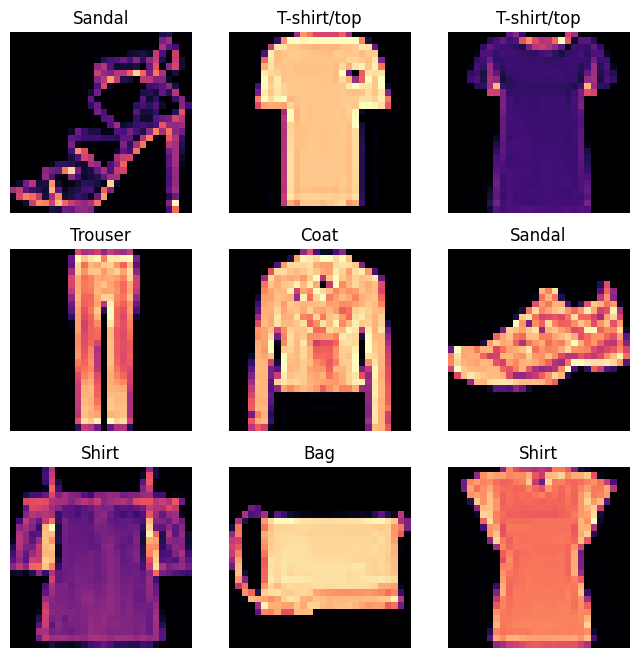

In [ ]:
#Visualise first 9 images from train dataset
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_images[i])
    plt.title(class_names[train_labels[i]])
    plt.axis('off')
    plt.set_cmap('magma')
plt.show()

In [ ]:
#Normalise pixel values too between 0 and 1 from 0 to 255 for better convergence.
#train_images, test_images = train_images.astype('float32') / 255.0, test_images.astype('float32') / 255.0
train_images, val_images, test_images = train_images / 255.0, val_images / 255.0, test_images / 255.0

# Prepare the data for the ANN

In [ ]:
#Flatten the image for the ANN to a 1D vector as expected input. CNN is 2D.
# Create new variables for the flattened data for the ANN
train_images_ann = train_images.reshape((train_images.shape[0], -1))
test_images_ann = test_images.reshape((test_images.shape[0], -1))
val_images_ann = val_images.reshape((val_images.shape[0], -1))

print("Training data shape for ANN:", train_images_ann.shape)
print("Testing data shape for ANN:", test_images_ann.shape)
print("Validation data shape for ANN:", val_images_ann.shape)

Training data shape for ANN: (50000, 784)
Testing data shape for ANN: (10000, 784)
Validation data shape for ANN: (10000, 784)


**Both CNN and ANN use the same one-hot encoder.**

In [ ]:
#One-hot encode the labels from categorical data (e.g. bag) into numerical format (0-9) - same for both because labels are the same
train_labels_one_hot = to_categorical(train_labels, num_classes=10)
test_labels_one_hot = to_categorical(test_labels, num_classes=10)
val_labels_one_hot = to_categorical(val_labels, num_classes=10)

# Prepare the data for the CNN

In [ ]:
#Data augmentation: increase the size and diversity of the training dataset to help the model better generalise unseen data and reduce overfitting using random flip
data_augmentation = tf.keras.Sequential([
    tf.keras.Input(shape=(28, 28, 1)), #Use input layer to avoid UserWarning
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

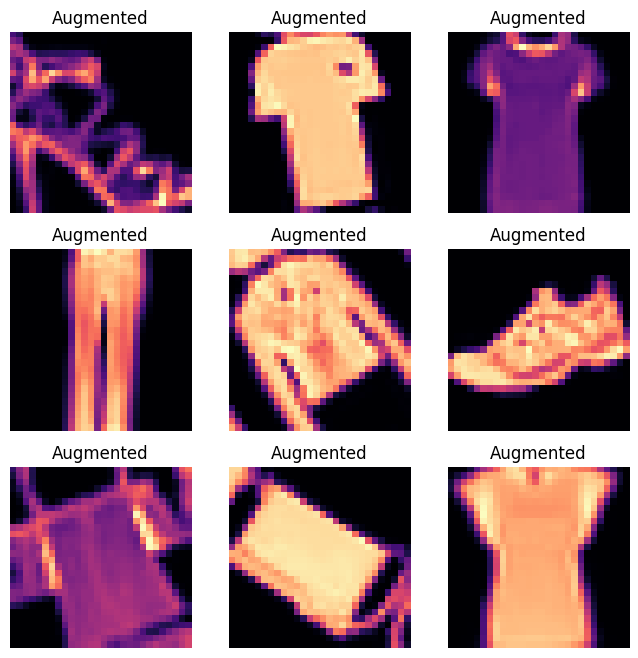

In [ ]:
#Visualise Augmented images
plt.figure(figsize=(8,8))
train_images_cnn = np.expand_dims(train_images.reshape(-1, 28, 28), -1) #unique to cnn

for i in range(9):
    #Add a batch dimension before augmenting
    augmented_image = data_augmentation(tf.expand_dims(train_images_cnn[i], 0))
    plt.subplot(3,3,i+1)
    #Remove the batch dimension before displaying
    plt.imshow(augmented_image[0])
    plt.title("Augmented")
    plt.axis('off')
plt.show()

In [ ]:
#Reshape image data for CNN by adding  dimension
train_images_cnn = np.expand_dims(train_images, axis=-1)
val_images_cnn = np.expand_dims(val_images, axis=-1)
test_images_cnn = np.expand_dims(test_images, axis=-1)

print("Training data shape for CNN:", train_images_cnn.shape)
print("Validation data shape for CNN:", val_images_cnn.shape)
print("Testing data shape for CNN:", test_images_cnn.shape)

Training data shape for CNN: (50000, 28, 28, 1)
Validation data shape for CNN: (10000, 28, 28, 1)
Testing data shape for CNN: (10000, 28, 28, 1)


# Design and implement the ANN model

In [ ]:
#Define the ANN model - dense layer = fully-connected layer - where every neuron is connected to every other neuron in the previous layer.
model_ann = models.Sequential([
    #layers.Dense(512, activation='relu', input_shape=(3072,)), - UserWarning aboout passing input_shape directly into dense layer in a sequential model, use input layer as the first layer.
    tf.keras.Input(shape=(784,)),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])
model_ann.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Compile the ANN model
model_ann.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#Train the ANN model with early stopping (monitor validation loss, stop if it doesn't improve for a specified number of epochs, and restore best weights).
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, #Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True #Whether to restore model weights from the epoch with the best value of the monitored quantity.
)

history_ann = model_ann.fit(
    train_images_ann, train_labels_one_hot,
    epochs = 50, #Iterations over the training dataset
    batch_size = 32,
    validation_data=(val_images_ann, val_labels_one_hot),
    callbacks=[early_stopping] #Eearly stopping callback
)

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7776 - loss: 0.6195 - val_accuracy: 0.8562 - val_loss: 0.3955
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8635 - loss: 0.3719 - val_accuracy: 0.8780 - val_loss: 0.3430
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8787 - loss: 0.3228 - val_accuracy: 0.8687 - val_loss: 0.3801
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8869 - loss: 0.3055 - val_accuracy: 0.8820 - val_loss: 0.3321
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8947 - loss: 0.2863 - val_accuracy: 0.8850 - val_loss: 0.3218
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9002 - loss: 0.2671 - val_accuracy: 0.8830 - val_loss: 0.3338
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9031 - loss: 0.2549 - val_accuracy: 0.8845 - val_loss: 0.3300
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9094 - loss: 0.2399 - 

# Design, compile and train the CNN model

In [ ]:
#Define the CNN model
model_cnn = models.Sequential([
    data_augmentation,  #Add augmented data to the first layer
    layers.Conv2D(32, (3, 3), activation='relu', ),  #Multi-convolutional layers with ReLU activation to learn hierarchical features. Removed: 'input_shape=(28, 28, 1)' it does it anyway and prevents the warning.
    layers.MaxPooling2D((2, 2)),    #Downsample the feature maps
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),   #Flatten into a 1D vector, which can be fed into dense layer.
    layers.Dense(64, activation='relu'),    #Classifers on the learned features
    layers.Dense(10, activation='softmax')  #Convert to probabilities for the 10 classes
])
model_cnn.summary()
#UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Compile the CNN model
model_cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the CNN model
from tensorflow.keras.callbacks import EarlyStopping

#Early stopping callback - monitor validation loss, stop if it doesn't improve for a specified number of epochs, and restore best weights
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, #Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True #Whether to restore model weights from the epoch with the best value.
)

history_cnn = model_cnn.fit(
    train_images_cnn, train_labels_one_hot,
    epochs = 50, #Iterations over the training dataset
    batch_size = 32,
    validation_data=(val_images_cnn, val_labels_one_hot),
    callbacks=[early_stopping] #Early stopping callback
)

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.6460 - loss: 0.9574 - val_accuracy: 0.7742 - val_loss: 0.6042
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7898 - loss: 0.5588 - val_accuracy: 0.8234 - val_loss: 0.4798
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.8201 - loss: 0.4872 - val_accuracy: 0.8250 - val_loss: 0.4665
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8367 - loss: 0.4390 - val_accuracy: 0.8315 - val_loss: 0.4596
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8472 - loss: 0.4051 - val_accuracy: 0.8547 - val_loss: 0.4065
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8539 - loss: 0.3963 - val_accuracy: 0.8484 - val_loss: 0.4111
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8628 - loss: 0.3689 - val_accuracy: 0.8621 - val_loss: 0.3806
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8669 - loss: 0

# Evaluate both models using the test accuracy, graphs and confusion matrices

# ANN

In [ ]:
#ANN test accuracy
test_loss_ann, test_acc_ann = model_ann.evaluate(test_images_ann, test_labels_one_hot, verbose = 2)
print('\nTest accuracy: ', test_acc_ann)

313/313 - 1s - 2ms/step - accuracy: 0.8831 - loss: 0.3379

Test accuracy:  0.8830999732017517


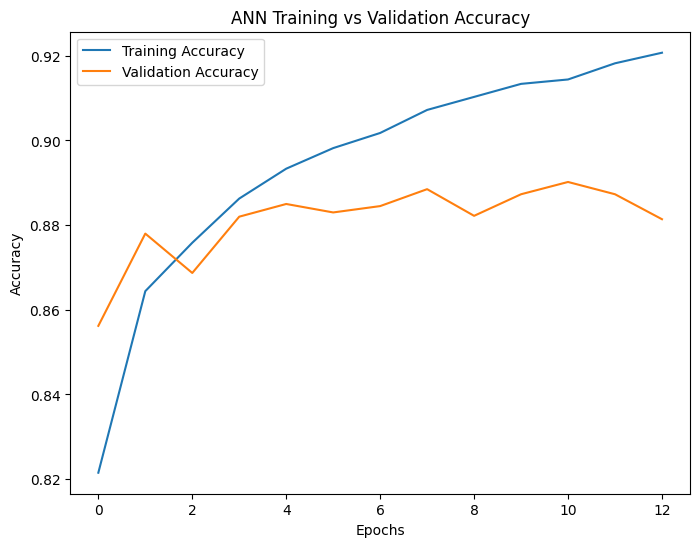

In [ ]:
#Visualise training accuracy for ANN on a graph
plt.figure(figsize=(8,6))
plt.plot(history_ann.history['accuracy'], label='Training Accuracy')
plt.plot(history_ann.history['val_accuracy'], label='Validation Accuracy')
plt.title('ANN Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


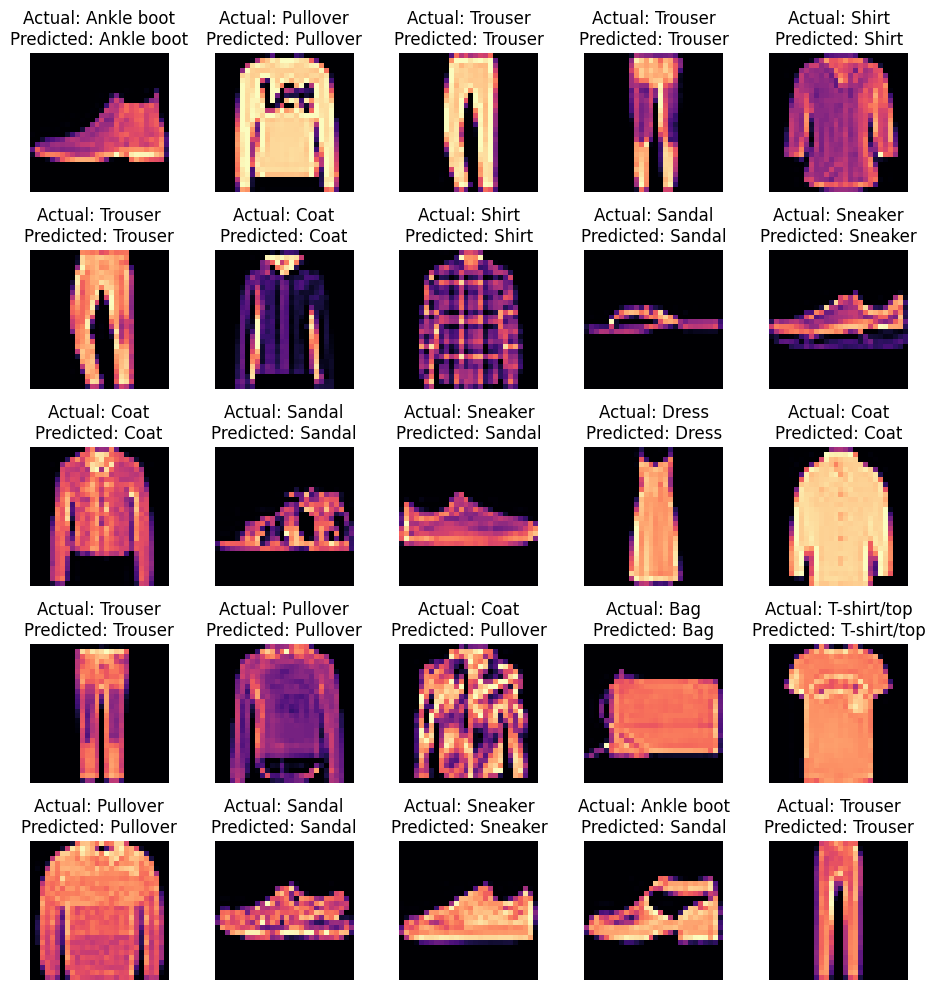

In [ ]:
#Predict and visualise the first 25 test images for ANN
predictions = model_ann.predict(test_images_ann[:25])
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"Actual: {class_names[test_labels[i]]}\nPredicted: {class_names[np.argmax(predictions[i])]}")
    plt.axis('off')
    plt.tight_layout()  #Helps to clean formatting
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


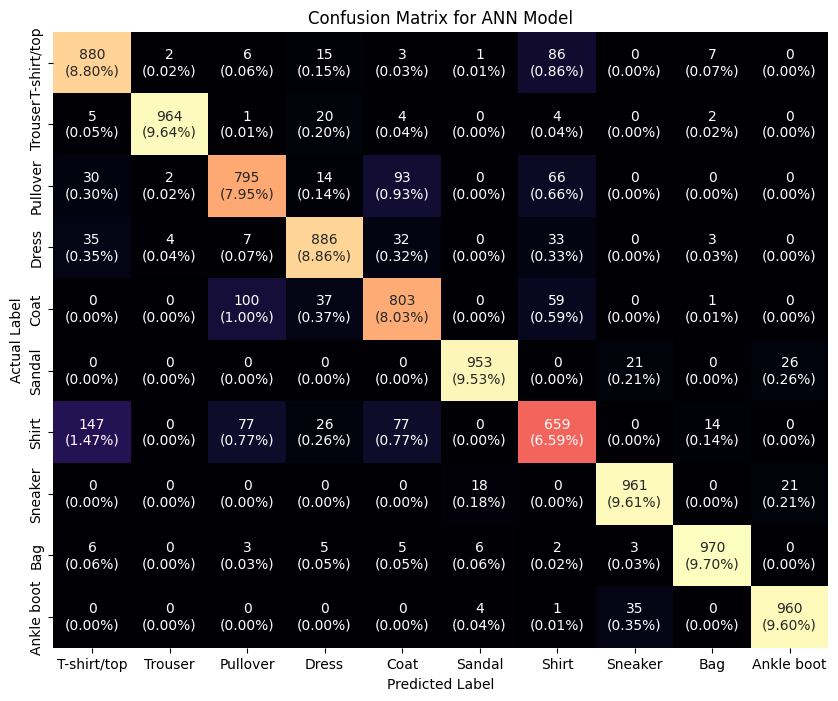

In [ ]:
#ANN confusion matrix for the test set of 10,000 images
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Making predictions using probabilities
ann_predictions = model_ann.predict(test_images_ann)
ann_predicted_labels = np.argmax(ann_predictions, axis=1)

#Calculate the count for each cell in the confusion matrix
cm_ann = confusion_matrix(test_labels, ann_predicted_labels)

#Normalise into a percentage.
cm_ann_normalized_total = cm_ann.astype('float') / cm_ann.sum()

#Custom annotations to show both count and percentage in same cell.
annot_labels = np.array([f'{raw_count}\n({percentage:.2%})'
                         for raw_count, percentage in zip(cm_ann.flatten(), cm_ann_normalized_total.flatten())]).reshape(cm_ann.shape)

#Visualise the confusion matrix.
plt.figure(figsize=(10, 8))
sns.heatmap(cm_ann, annot=annot_labels, fmt='s', cmap='magma', xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix for ANN Model')
plt.show()
#print("Total:" + str(np.sum(cm_ann)))

# CNN

In [ ]:
#CNN test accuracy
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(test_images_cnn, test_labels_one_hot, verbose = 2)
print('\nTest accuracy: ', test_acc_cnn)

313/313 - 1s - 3ms/step - accuracy: 0.8777 - loss: 0.3522

Test accuracy:  0.8776999711990356


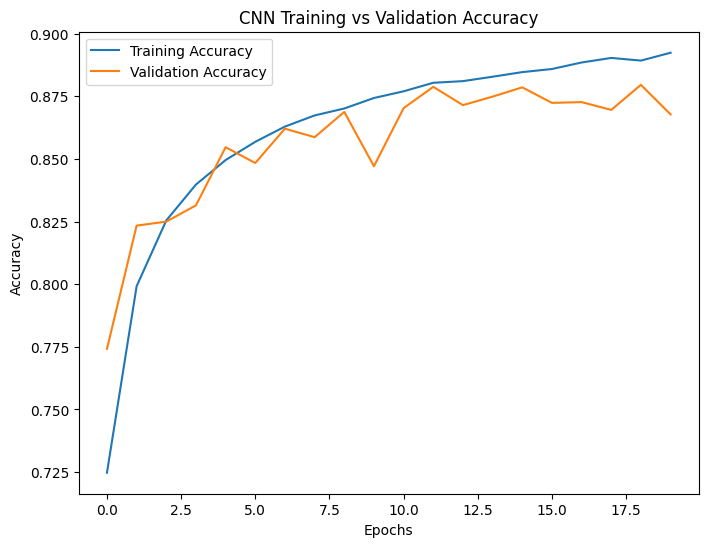

In [ ]:
#Visualise training acuracy for CNN
plt.figure(figsize=(8,6))
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


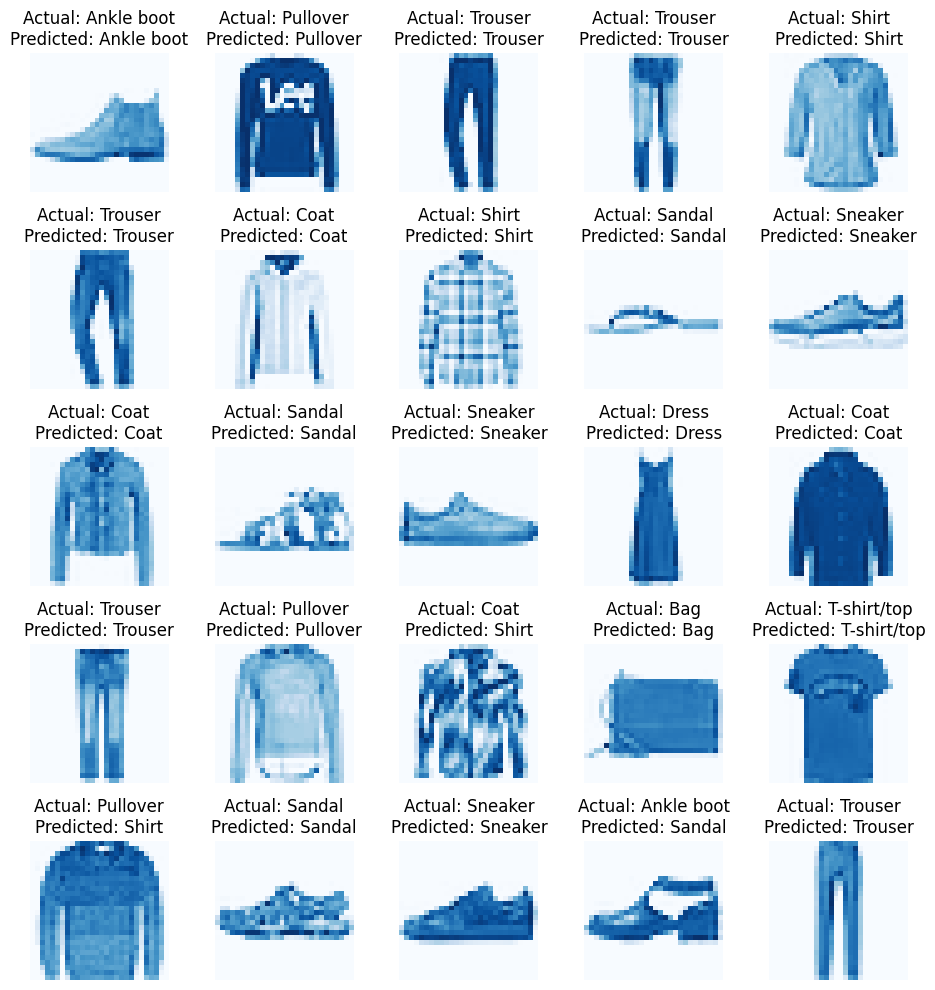

In [ ]:
#Predict and visualise the first 25 test images for CNN
predictions = model_cnn.predict(test_images_cnn[:25])
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_images_cnn[i].reshape(28, 28), cmap= 'Blues') #Reshape the test images
    plt.title(f"Actual: {class_names[test_labels[i]]}\nPredicted: {class_names[np.argmax(predictions[i])]}")
    plt.axis('off')
    plt.tight_layout()  #Helps to clean formatting
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


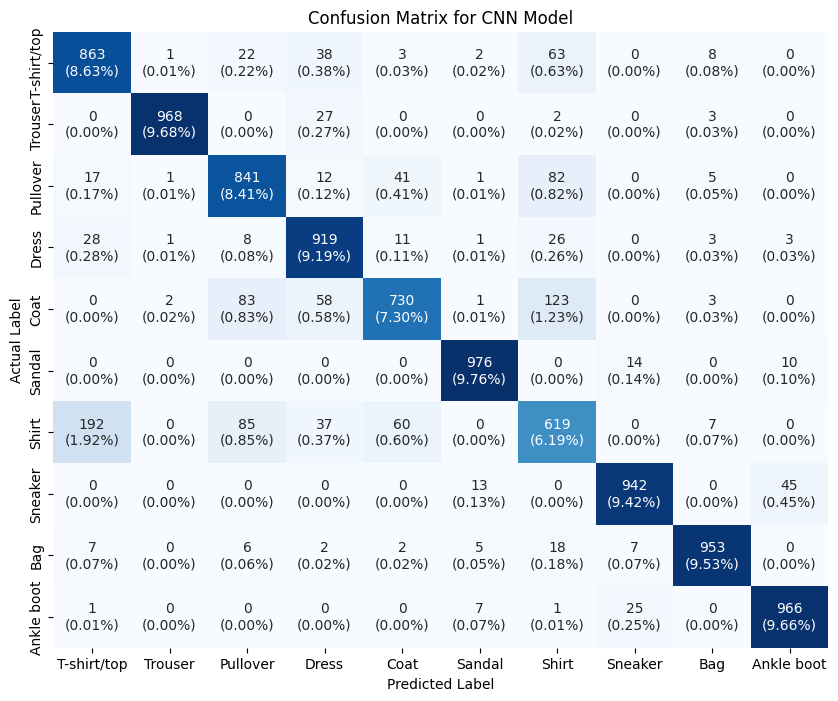

In [ ]:
#CNN confusion matrix for test set of 10,000 images
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Making predictions using probabilities
cnn_predictions = model_cnn.predict(test_images_cnn)
cnn_predicted_labels = np.argmax(cnn_predictions, axis= 1 )

#Calculate the count for confusion matrix
cm_cnn = confusion_matrix(test_labels, cnn_predicted_labels)

# Calculate the percentage
cm_cnn_normalized_total = cm_cnn.astype('float') / cm_cnn.sum()

#Put the count and percentage in the same cell.
annot_labels = np.array([f'{raw_count}\n({percentage:.2%})'
                         for raw_count, percentage in zip(cm_cnn.flatten(), cm_cnn_normalized_total.flatten())]).reshape(cm_cnn.shape)

# Visualize the confusion matrix
plt.figure(figsize = (10, 8))
sns.heatmap(cm_cnn, annot=annot_labels, fmt='s', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False) # Use 's' format for string annotations
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix for CNN Model')
plt.show()

# Visualising the internal structure of my ANN and CNN

Visualising Original ANN Model: 


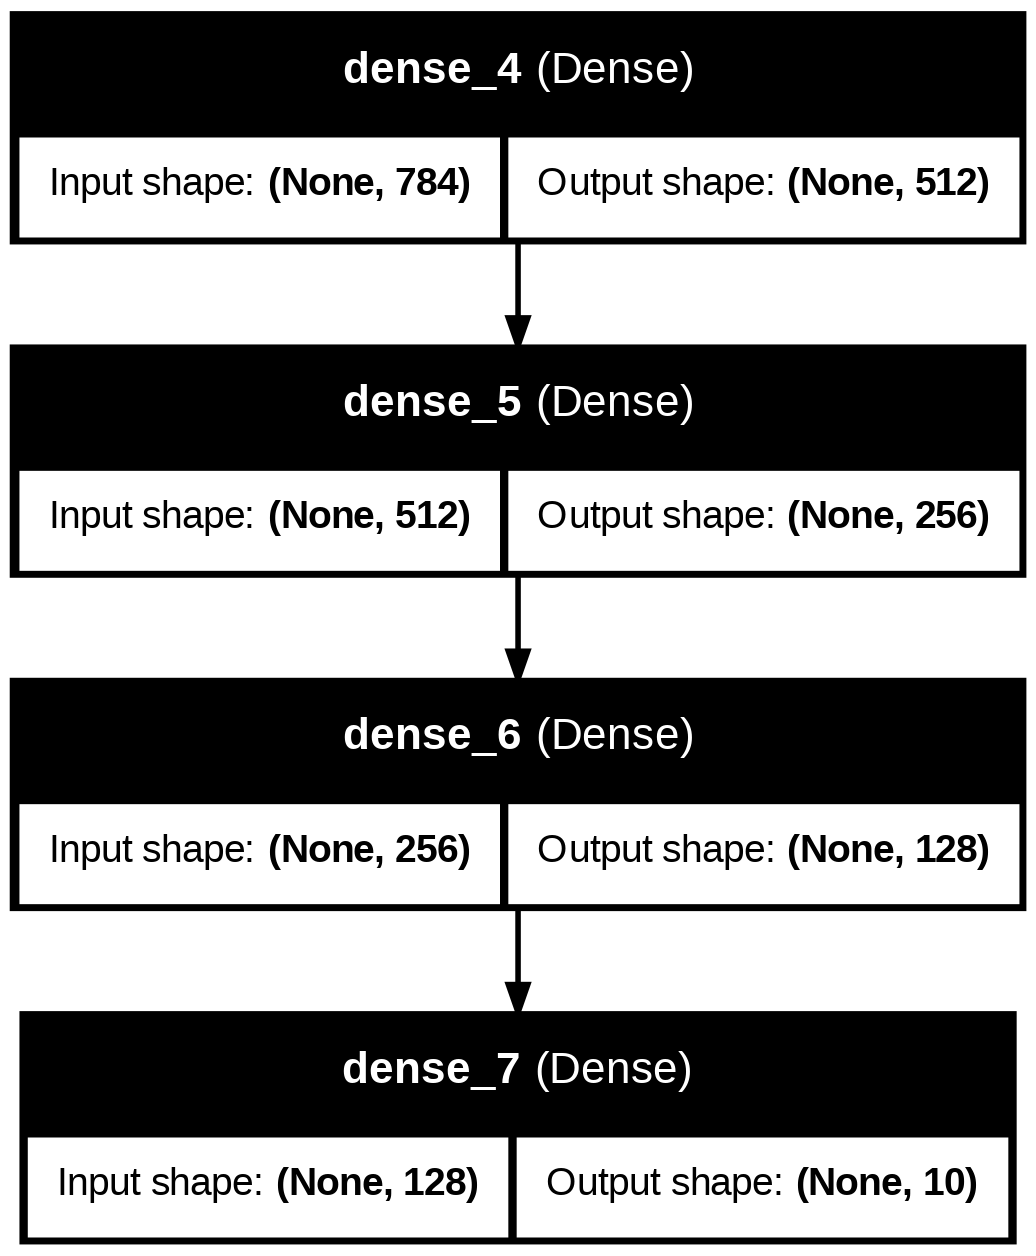

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
print("Visualising Original ANN Model: ")
plot_model(model_ann, to_file='model_ann.png', show_shapes=True, show_layer_names=True)
display(Image('model_ann.png'))

Visualising Original CNN Model: 


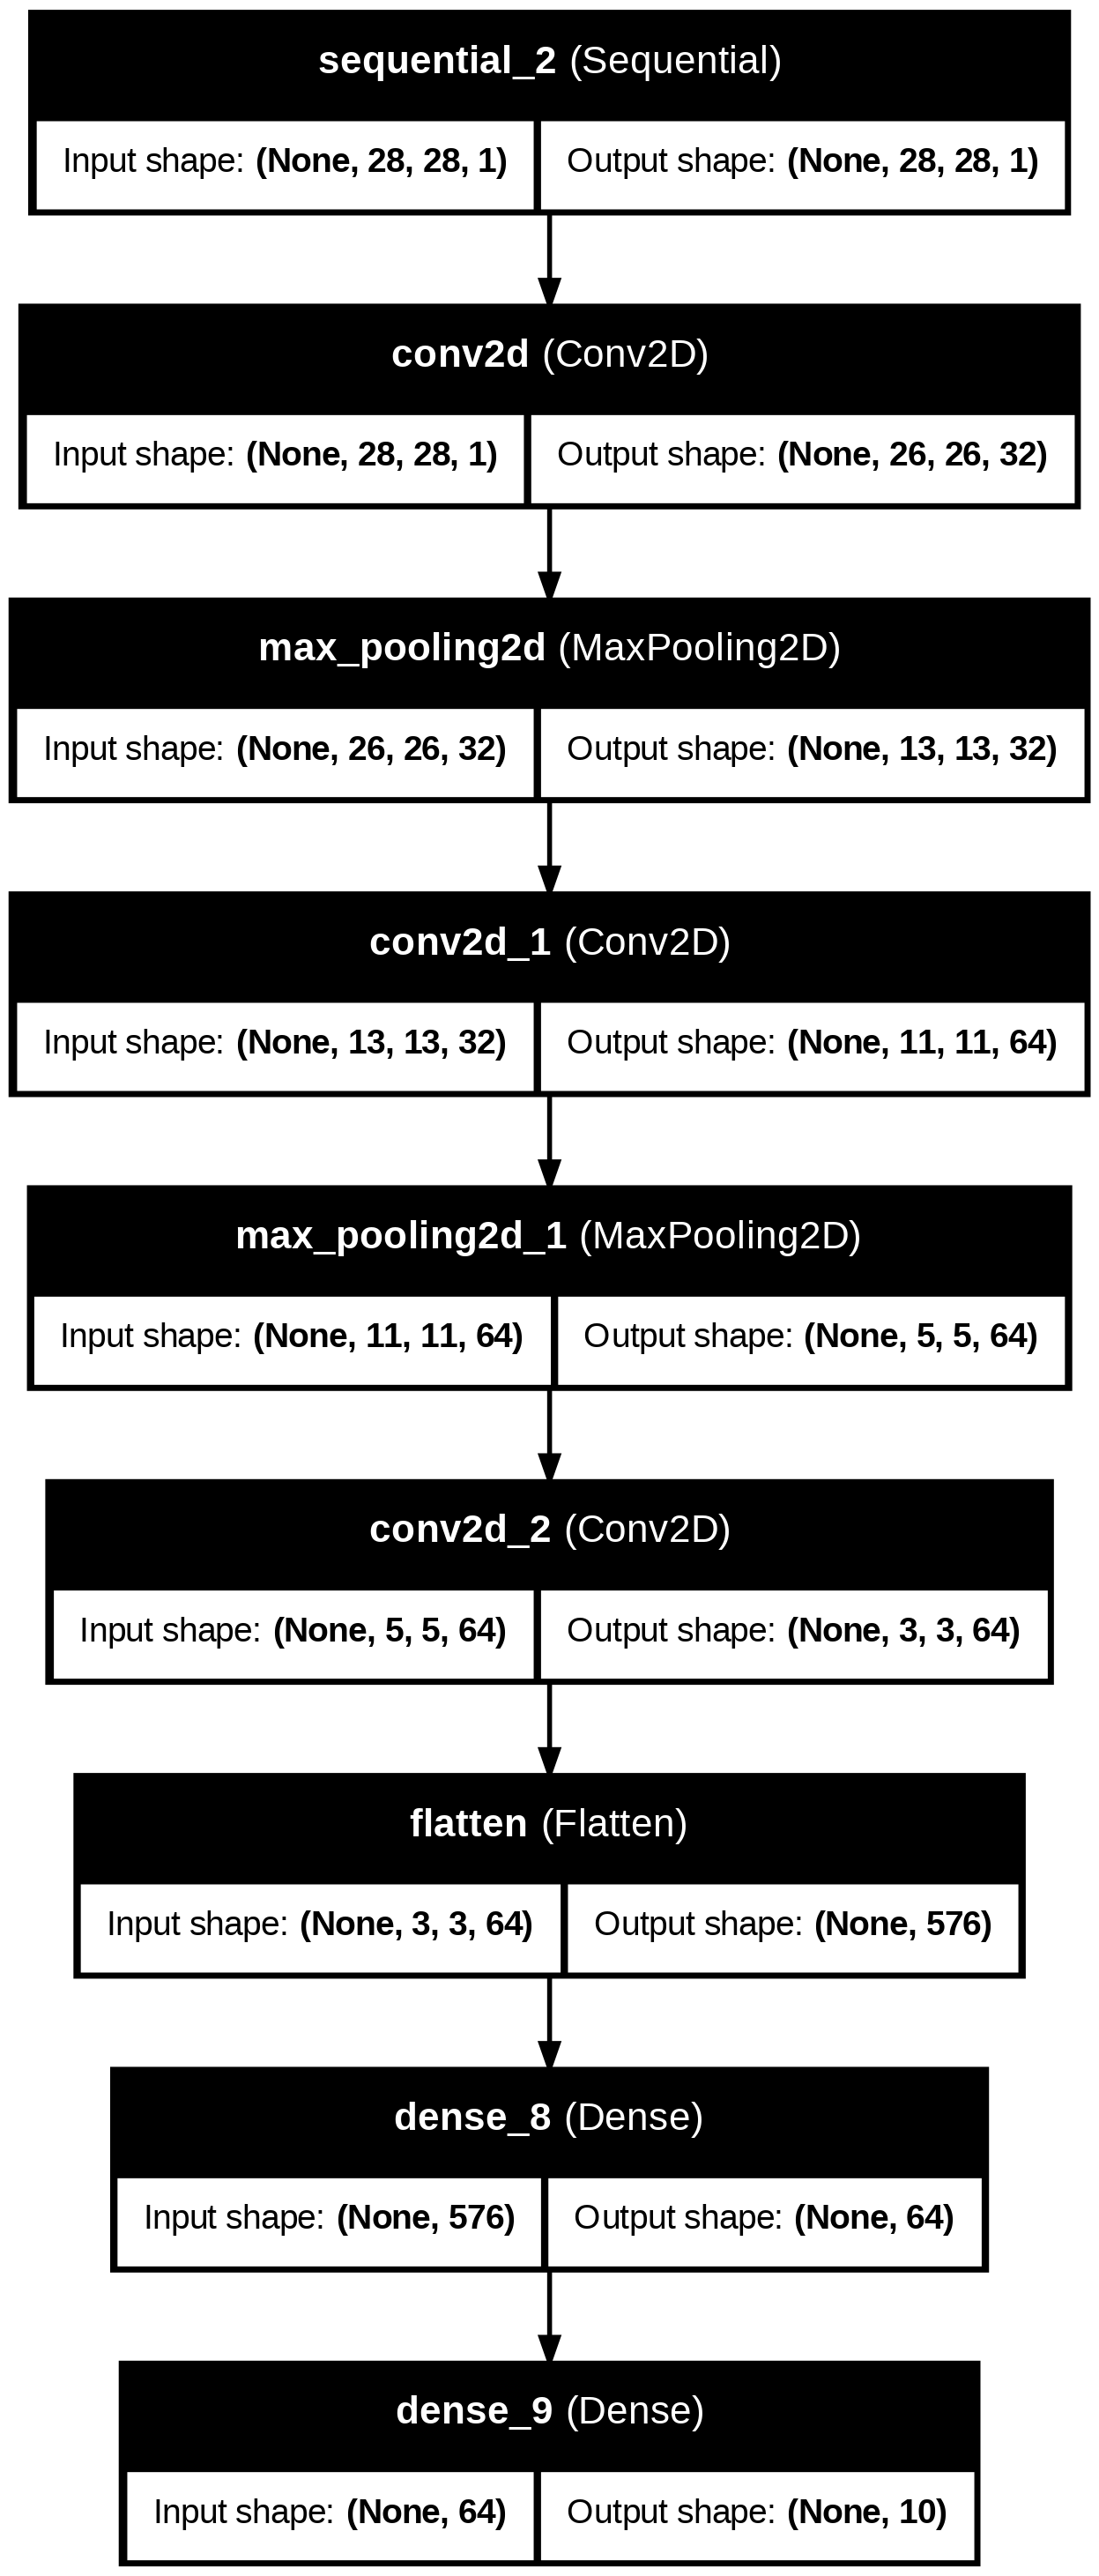

In [ ]:
# Visualise the original CNN model and display it
print("Visualising Original CNN Model: ")
plot_model(model_cnn, to_file='model_cnn.png', show_shapes=True, show_layer_names=True)
display(Image('model_cnn.png'))

# Analyse and compare the performance of the ANN and CNN on the same Fashion-MNIST dataset.

The ANN has an overall test accuracy of 0.8831, which is slightly higher than the CNN's accuracy of 0.8777. ANN also has a lower loss of 0.3379 to 0.3522. Both models ran quickly and had similar step speeds of 2 ms/step for ANN and 3 ms/step for CNN. CNNs typically outperform ANNs when classifying images due to their ability to capture spatial features (e.g. 2D rather than 1D), parameter sharing and use of convolutional layers which help to detect patterns. The training history plots for both ANN and CNN look similar to each other, with the former narrowly having the better performance across the epochs from start to finish for all evaluation metrics. The metrics in both models are tracking in the right direction, and the gap between the training and validation accuracy appears to be stable. The same goes for training and validation loss.

Looking at the curves for both models, you can see that both models' plateau. I have used early stopping to ensure that the program does not run extra epochs if it is no longer improving. This happens after 13 epochs for ANN and 20 for CNN. This indicates that ANN outperforms CNN in the learning process. The model plateaus because validation accuracy has started to fluctuate between decreasing and then increasing. This is caused by overfitting, which occurs when the model is learning the training data too well. As a result, the model performs poorly on unseen data in the test and validation datasets. Overall, the accuracy improves gradually in both models, with ANN being slightly ahead of CNN, and both models perform moderately better on data it has seen.

To prevent overfitting, I could implement a regularisation technique. Below this cell, I created a new model for ANN and CNN that uses dropout regularisation. I compared this to the previous cells that did not use regularisation to see the difference. I set the dropout value to 0.1, because if the rate is too high, it could cause the model to underfit rather than overfit. This is because it will deactivate too many neurons, so the model fails to capture enough patterns in the data. Looking at the graphs below, contrasting ANN and CNN with or without regularisation, I can see that dropout performs similarly but slightly worse on both models in terms of accuracy (ANN: 0.8805 and CNN: 0.8747). Both models used 15 epochs.

The confusion matrices for ANN and CNN look similar for the 10,000 items of clothing in the test set. The diagonal line of a stronger shade starting top left and ending bottom right shows that most items of clothing are correctly labelled (e.g. actual label matches predicted label). We look at the cells not on this diagonal to see what each model has misclassified what item of clothing. The larger the count/percentage off diagonal, the more items that were misclassified. For the confusion matrices I created for ANN and CNN models using dropout, you can see less clothing items incorrectly identified for CNN but not ANN.

For example, a shirt has a habit of being misidentified as a t-shirt, pullover, or coat. ANN misclassified 147 shirts as t-shirts, 77 as pullovers and 77 as coats, compared to 192, 85 and 60, respectively. Other common misclassifications in both models include actual coat and predicted pullover, actual t-shirt and predicted shirt and actual ankle boot vs sneaker.

To improve performance for both models, especially the CNN, I could try different learning rates or optimisers like SGD with momentum, as well as increase the number of epochs or batch sizes. Adam is the most popular optimiser; they adjust the model's internal parameters like weights and biases to minimise loss. RMSprop and Adagrad are more similar optimisers to Adam in adapting the learning rate for each parameter based on the history of gradients.

I could implement more aggressive types of data augmentation and see what happens or merely add more layers to the network. Again, I can experiment with changing the number of filters, different kernel sizes, or pooling strategies like global average pooling rather than flattening before the final dense layer. For more complex classification tasks, I could utilise transfer learning, where I employ a pre-trained CNN model, such as ResNet, which can significantly enhance performance.

Overall, the model that performs the best is ANN without dropout regularisation, although all models perform similarly. The main weakness for ANN and CNN is distinguishing between items of similar shape, such as several types of tops (shirts, coats, and pullovers). Future work should include tuning hyperparameters for both models and implementing a more complex CNN architecture like VGG or ResNet to see if they can better capture spatial hierarchies and overcome the ANN's performance.

Owen Cooke

P2661071

# Design and implement the ANN model with Dropout

In [ ]:
#Define the ANN model with Dropout regularisation
model_ann_regularised = models.Sequential([
    tf.keras.Input(shape=(784,)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.1), #Add Dropout layer
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1), #Add Dropout layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1), #Add Dropout layer
    layers.Dense(10, activation='softmax')
])
model_ann_regularised.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

#Train the ANN model with Dropout

In [ ]:
#Train the ANN model with Dropout
model_ann_regularised.compile(optimizer='adam',
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])


history_ann_regularized = model_ann_regularised.fit(
    train_images_ann, train_labels_one_hot,
    epochs=50,
    batch_size=32,
    validation_data=(val_images_ann, val_labels_one_hot),
    callbacks=[early_stopping]
)

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7583 - loss: 0.6742 - val_accuracy: 0.8425 - val_loss: 0.4342
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8509 - loss: 0.4030 - val_accuracy: 0.8613 - val_loss: 0.3765
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8661 - loss: 0.3619 - val_accuracy: 0.8698 - val_loss: 0.3532
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8779 - loss: 0.3297 - val_accuracy: 0.8719 - val_loss: 0.3476
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8812 - loss: 0.3185 - val_accuracy: 0.8784 - val_loss: 0.3319
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8871 - loss: 0.3047 - val_accuracy: 0.8806 - val_loss: 0.3263
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8903 - loss: 0.2960 - val_accuracy: 0.8839 - val_loss: 0.3243
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8933 - loss: 0.2833 -

# Compare ANN Models with and without regularisation

In [ ]:
#Test accuracy
test_loss_ann_regularised, test_acc_ann_regularised = model_ann_regularised.evaluate(test_images_ann, test_labels_one_hot, verbose = 2)
print('\nTest accuracy: ', test_acc_ann_regularised)

313/313 - 1s - 2ms/step - accuracy: 0.8805 - loss: 0.3370

Test accuracy:  0.8805000185966492


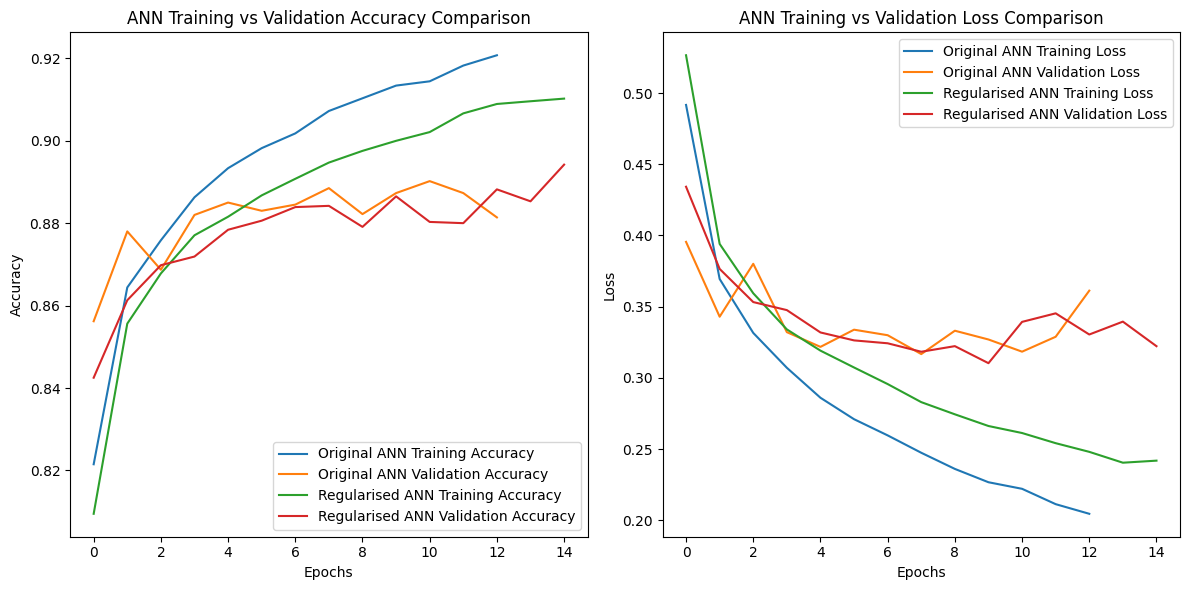

In [ ]:
#Plot training and validation accuracy for original and regularised ANN
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_ann.history['accuracy'], label='Original ANN Training Accuracy')
plt.plot(history_ann.history['val_accuracy'], label='Original ANN Validation Accuracy')
plt.plot(history_ann_regularized.history['accuracy'], label='Regularised ANN Training Accuracy')
plt.plot(history_ann_regularized.history['val_accuracy'], label='Regularised ANN Validation Accuracy')
plt.title('ANN Training vs Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#Plot training and validation loss for original and regularised ANN
plt.subplot(1, 2, 2)
plt.plot(history_ann.history['loss'], label='Original ANN Training Loss')
plt.plot(history_ann.history['val_loss'], label='Original ANN Validation Loss')
plt.plot(history_ann_regularized.history['loss'], label='Regularised ANN Training Loss')
plt.plot(history_ann_regularized.history['val_loss'], label='Regularised ANN Validation Loss')
plt.title('ANN Training vs Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


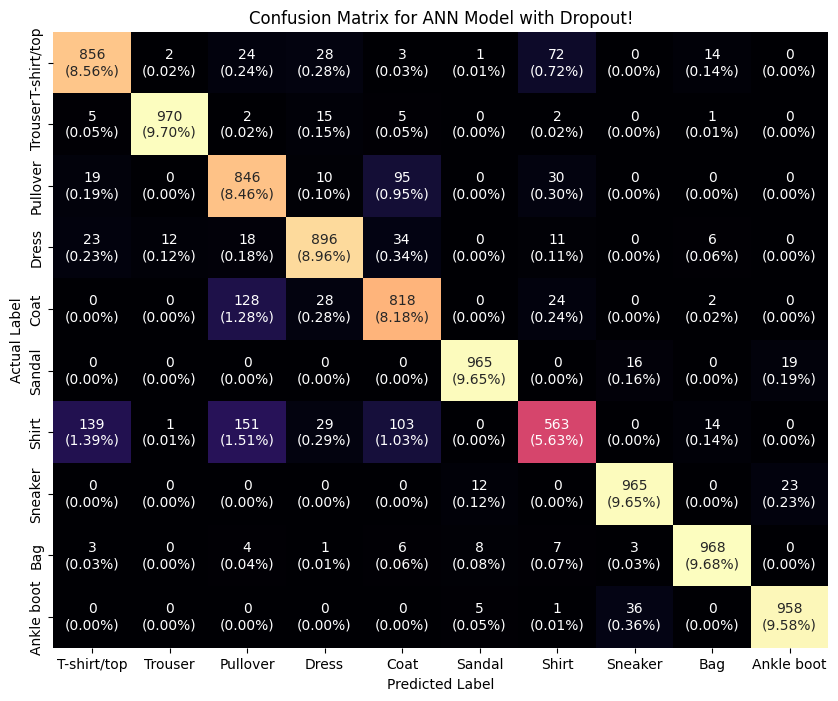

In [ ]:
#ANN with dropout confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Making predictions using probabilities
ann_regularized_predictions = model_ann_regularised.predict(test_images_ann)
ann_regularized_predicted_labels = np.argmax(ann_regularized_predictions, axis=1)
#Calculate the count for each cell in the confusion matrix
cm_ann_regularized = confusion_matrix(test_labels, ann_regularized_predicted_labels)
#Normalise into a percentage.
cm_ann_regularized_normalized_total = cm_ann_regularized.astype('float') / cm_ann_regularized.sum()
#Custom annotations to show both count and percentage in same cell.
annot_labels_regularized = np.array([f'{raw_count}\n({percentage:.2%})'
                         for raw_count, percentage in zip(cm_ann_regularized.flatten(), cm_ann_regularized_normalized_total.flatten())]).reshape(cm_ann_regularized.shape)

#Visualise
plt.figure(figsize=(10, 8))
sns.heatmap(cm_ann_regularized, annot=annot_labels_regularized, fmt='s', cmap='magma', xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix for ANN Model with Dropout!')
plt.show()

# Design and implement the CNN model with Dropout

In [ ]:
#Define the CNN model with Dropout regularization
model_cnn_regularised = models.Sequential([
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1), #Add Dropout layer
    layers.Dense(10, activation='softmax')
])
model_cnn_regularised.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

#Train the CNN model with Dropout

In [ ]:
#Compile the CNN model with Dropout
model_cnn_regularised.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

#Train the CNN model with Dropout
history_cnn_regularised = model_cnn_regularised.fit(
    train_images_cnn, train_labels_one_hot,
    epochs=50,
    batch_size=32,
    validation_data=(val_images_cnn, val_labels_one_hot),
    callbacks=[early_stopping]
)

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.6219 - loss: 1.0255 - val_accuracy: 0.8060 - val_loss: 0.5362
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.7876 - loss: 0.5627 - val_accuracy: 0.8255 - val_loss: 0.4686
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.8139 - loss: 0.4954 - val_accuracy: 0.8209 - val_loss: 0.4681
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8345 - loss: 0.4473 - val_accuracy: 0.8119 - val_loss: 0.5154
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8450 - loss: 0.4217 - val_accuracy: 0.8538 - val_loss: 0.3924
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8519 - loss: 0.4009 - val_accuracy: 0.8543 - val_loss: 0.3956
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8549 - loss: 0.3881 - val_accuracy: 0.8636 - val_loss: 0.3741
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8597 - loss: 

# Compare CNN Models with and without regularisation

In [ ]:
#Test accuracy
test_loss_cnn_regularised, test_acc_cnn_regularised = model_cnn_regularised.evaluate(test_images_cnn, test_labels_one_hot, verbose = 2)
print('\nTest accuracy: ', test_acc_cnn_regularised)

313/313 - 1s - 3ms/step - accuracy: 0.8747 - loss: 0.3509

Test accuracy:  0.8747000098228455


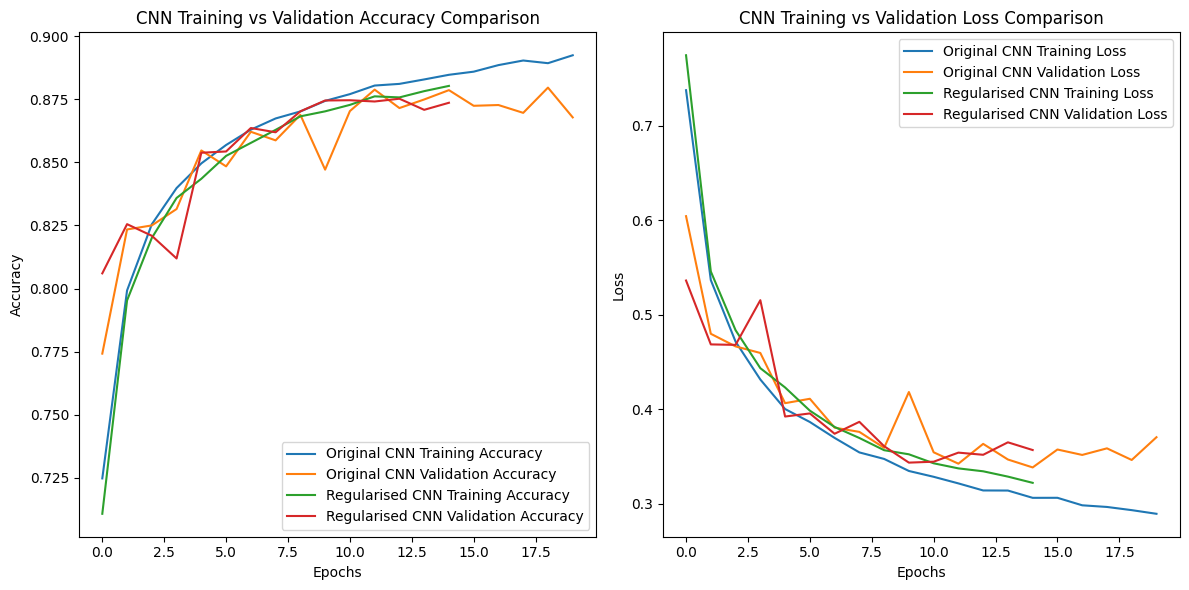

In [ ]:
# Plot training and validation accuracy for original and regularised CNN
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Original CNN Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Original CNN Validation Accuracy')
plt.plot(history_cnn_regularised.history['accuracy'], label='Regularised CNN Training Accuracy')
plt.plot(history_cnn_regularised.history['val_accuracy'], label='Regularised CNN Validation Accuracy')
plt.title('CNN Training vs Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss for original and regularised CNN
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Original CNN Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Original CNN Validation Loss')
plt.plot(history_cnn_regularised.history['loss'], label='Regularised CNN Training Loss')
plt.plot(history_cnn_regularised.history['val_loss'], label='Regularised CNN Validation Loss')
plt.title('CNN Training vs Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


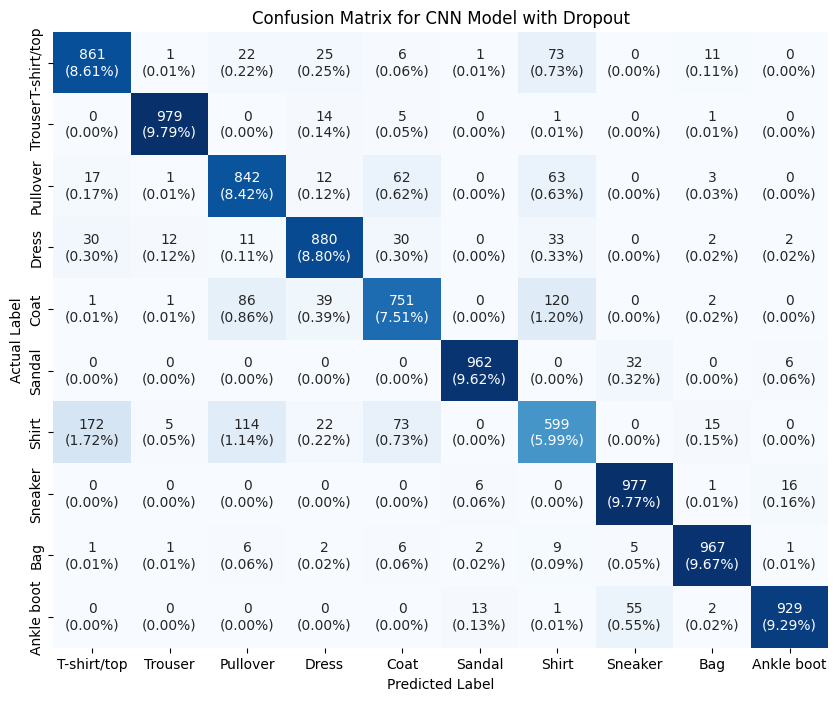

In [ ]:
#CNN with dropout confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Making predictions using probabilities
cnn_regularized_predictions = model_cnn_regularised.predict(test_images_cnn)
cnn_regularized_predicted_labels = np.argmax(cnn_regularized_predictions, axis= 1 )
#Calculate the count for confusion matrix
cm_cnn_regularized = confusion_matrix(test_labels, cnn_regularized_predicted_labels)
#Calculate the percentage
cm_cnn_regularized_normalized_total = cm_cnn_regularized.astype('float') / cm_cnn_regularized.sum()
#Put the count and percentage in the same cell.
annot_labels_regularized = np.array([f'{raw_count}\n({percentage:.2%})'
                         for raw_count, percentage in zip(cm_cnn_regularized.flatten(), cm_cnn_regularized_normalized_total.flatten())]).reshape(cm_cnn_regularized.shape)

#Visualize
plt.figure(figsize = (10, 8))
sns.heatmap(cm_cnn_regularized, annot=annot_labels_regularized, fmt='s', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix for CNN Model with Dropout')
plt.show()